# Feature Imputation with a Heat Flux Dataset

## Dataset Overview

- pressure: pressure of the pressurized water reactor (boiling system) in MPa (kg/m·s²)

- x_e_out: equilibrium (or thermodynamic) quality. An adimensional factor.

- mass flux: amount of mass that passes through a given area per unit of time (kg/m2·s)

- D_e: channel equivalent (or hydraulic) diameter (mm). In simple words its just a concept that simplifies the analysis of flow in non-circular geometries by considering an equivalent circular channel with the same hydraulic resistance. It is a characteristic length scale used to describe the flow of fluid through a channel, duct, or pipe of non-circular cross-section.

- D_h: channel heated diameter (mm). I couldn't find a formal defintion but my intuition is that the diameter expands when being heated.

- L_h: heated length (mm).

- chf_exp: experimental critical heat flux. Is a regulatory limit for commercial pressurized water reactors (PWRs) worldwide. Its unit is MW/m2 or in SI base units (kg/s³).

## Import Libraries

In [60]:
# Pre-
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model building
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import optuna

# Warnings
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from helper_functions import data_summary, corr_heatmap

## Dataset Analysis

In [5]:
df = pd.read_csv('data.csv')
df.head()

id    author geometry  pressure [MPa]  mass_flux [kg/m2-s]  x_e_out [-]   
0   0  Thompson     tube            7.00               3770.0       0.1754  \
1   1  Thompson     tube             NaN               6049.0      -0.0416   
2   2  Thompson      NaN           13.79               2034.0       0.0335   
3   3      Beus  annulus           13.79               3679.0      -0.0279   
4   4       NaN     tube           13.79                686.0          NaN   

   D_e [mm]  D_h [mm]  length [mm]  chf_exp [MW/m2]  
0       NaN      10.8        432.0              3.6  
1      10.3      10.3        762.0              6.2  
2       7.7       7.7        457.0              2.5  
3       5.6      15.2       2134.0              3.0  
4      11.1      11.1        457.0              2.8

We can simplify the feature names:

In [6]:
df = df.rename(columns={'pressure [MPa]' : 'pressure', 
                        'mass_flux [kg/m2-s]': 'mass_flux', 
                        'x_e_out [-]': 'x_e_out', 
                        'D_e [mm]': 'D_e',
                        'D_h [mm]': 'D_h',
                        'length [mm]': 'length',
                        'chf_exp [MW/m2]': 'chf_exp'})

We can use the pre-defined summary function to see an analysis of the numerical features:

In [ ]:
def data_summary(df):
        print(f"Dataset has {df.shape[1]-1} features and {df.shape[0]} samples")
        summary = pd.DataFrame(index=df.columns)
        desc = pd.DataFrame(df.describe(include='all').transpose())
        summary["Count"] = desc['count'].values
        summary["Unique"] = df.nunique().values
        summary["Missing"] = df.isnull().sum().values
        summary["Duplicated"] = df.duplicated().sum()
        summary['Std'] = desc['std'].values
        summary["Mode"] = df.mode().values[0]
        summary["Median"] = df.median()
        summary['Mean'] = desc['mean'].values
        summary['Min'] = desc['min'].values
        summary['Max'] = desc['max'].values
        summary["First Value"] = df.loc[0].values
        summary["Last Value"] = df.loc[df.shape[0]-1].values
        summary["Types"] = df.dtypes
        return summary

In [7]:
data_summary(df.select_dtypes(include='number'))

Dataset has 7 features and 31644 samples


Count  Unique  Missing  Duplicated          Std       Mode   
id         31644.0   31644        0           0  9134.980296     0.0000  \
pressure   27192.0     144     4452           0     4.333683    13.7900   
mass_flux  26853.0     733     4791           0  1777.032080  4069.0000   
x_e_out    21229.0    1682    10415           0     0.100911     0.0334   
D_e        26156.0      43     5488           0     5.185692    10.3000   
D_h        27055.0      49     4589           0    19.838489    10.3000   
length     26885.0      70     4759           0   672.299239   457.0000   
chf_exp    31644.0     109        0           0     1.983991     2.3000   

               Median          Mean      Min        Max  First Value   
id         15821.5000  15821.500000   0.0000  31643.000       0.0000  \
pressure      11.0700     10.640747   0.1000     20.680       7.0000   
mass_flux   2731.0000   3068.011023   0.0000   7975.000    3770.0000   
x_e_out        0.0038     -0.000453  -0.8667      0.232       0.1754   
D_e            7.8000      8.629255   1.0000     37.500          NaN   
D_h           10.0000     14.174330   1.0000    120.000      10.8000   
length       610.0000    832.987391  10.0000   3048.000     432.0000   
chf_exp        3.4000      3.796985   0.8000     19.300       3.6000   

           Last Value    Types  
id         31643.0000    int64  
pressure       6.8900  float64  
mass_flux   7568.0000  float64  
x_e_out        0.0603  float64  
D_e           12.8000  float64  
D_h           12.8000  float64  
length      1930.0000  float64  
chf_exp        3.3000  float64

We can also look into the two categorical features:

In [8]:
df.select_dtypes(include='object').describe()

author geometry
count      26620    26144
unique        10        3
top     Thompson     tube
freq       17396    21145

We can see that we have a lot of missing values for this dataset, especially with x_e_out which will be our main focus. Therefore we can split the dataset into a train and test dataset based on whether these values are missing or not:

In [9]:
df_train = df[df['x_e_out'].isna() == False].reset_index(drop=True)
df_test = df[df['x_e_out'].isna() == True].reset_index(drop=True)

In [10]:
print('Training Data:', df_train.shape)
print('Test Data:', df_test.shape)

Training Data: (21229, 10)
Test Data: (10415, 10)


## Categorical Feature Analysis

We can see that we have a fair few missing values for our categorical columns:

In [11]:
# Check the number of missing values
print('Missing author rows (train):', df_train.author.isna().sum())
print('Missing author rows (test):', df_test.author.isna().sum())
print('\n')
print('Missing geometry rows (train):', df_train.geometry.isna().sum())
print('Missing geometry rows (test):', df_test.geometry.isna().sum())


Missing author rows (train): 3403
Missing author rows (test): 1621


Missing geometry rows (train): 3713
Missing geometry rows (test): 1787


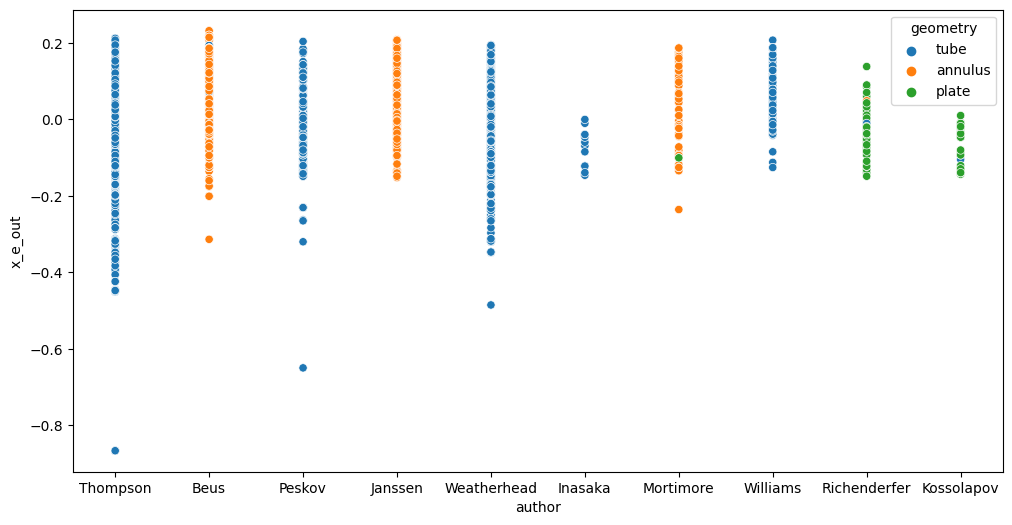

In [12]:
# Plot a scatter graph
plt.figure(figsize=(12, 6))
sns.scatterplot(data = df_train,  x='author', y='x_e_out', hue='geometry');

We can see that there is a clear correlation between certain authors and geometries, so we can use these to fill in this missing values for each category:

In [13]:
# Fill values with tube
tube_mask_train = df_train['author'].isin(['Thompson', 'Peskov', 'Weatherhead', 'Inasaka', 'Williams'])
tube_mask_test = df_test['author'].isin(['Thompson', 'Peskov', 'Weatherhead', 'Inasaka', 'Williams'])
df_train.loc[tube_mask_train, 'geometry'] = df_train.loc[tube_mask_train, 'geometry'].fillna('tube')
df_test.loc[tube_mask_test, 'geometry'] = df_test.loc[tube_mask_test, 'geometry'].fillna('tube')

# Fill values with annulus
annulus_mask_train = df_train['author'].isin(['Beus', 'Janssen', 'Mortimore'])
annulus_mask_test = df_test['author'].isin(['Beus', 'Janssen', 'Mortimore'])
df_train.loc[annulus_mask_train, 'geometry'] = df_train.loc[annulus_mask_train, 'geometry'].fillna('annulus')
df_test.loc[annulus_mask_test, 'geometry'] = df_test.loc[annulus_mask_test, 'geometry'].fillna('annulus')

# Fill values with plate
plate_mask_train = df_train['author'].isin(['Richenderfer', 'Kossolapov'])
plate_mask_test = df_test['author'].isin(['Richenderfer', 'Kossolapov'])
df_train.loc[plate_mask_train, 'geometry'] = df_train.loc[plate_mask_train, 'geometry'].fillna('plate')
df_test.loc[plate_mask_test, 'geometry'] = df_test.loc[plate_mask_test, 'geometry'].fillna('plate')

In [14]:
# Check the number of missing values
print('Missing author rows (train):', df_train.author.isna().sum())
print('Missing author rows (test):', df_test.author.isna().sum())
print('\n')
print('Missing geometry rows (train):', df_train.geometry.isna().sum())
print('Missing geometry rows (test):', df_test.geometry.isna().sum())

Missing author rows (train): 3403
Missing author rows (test): 1621


Missing geometry rows (train): 598
Missing geometry rows (test): 268


We can see that this has significantly reduced the number of missing values for the geometry feature, however there are still some left where the author column was still missing. 

We can now look at filling in the missing values for the author column:

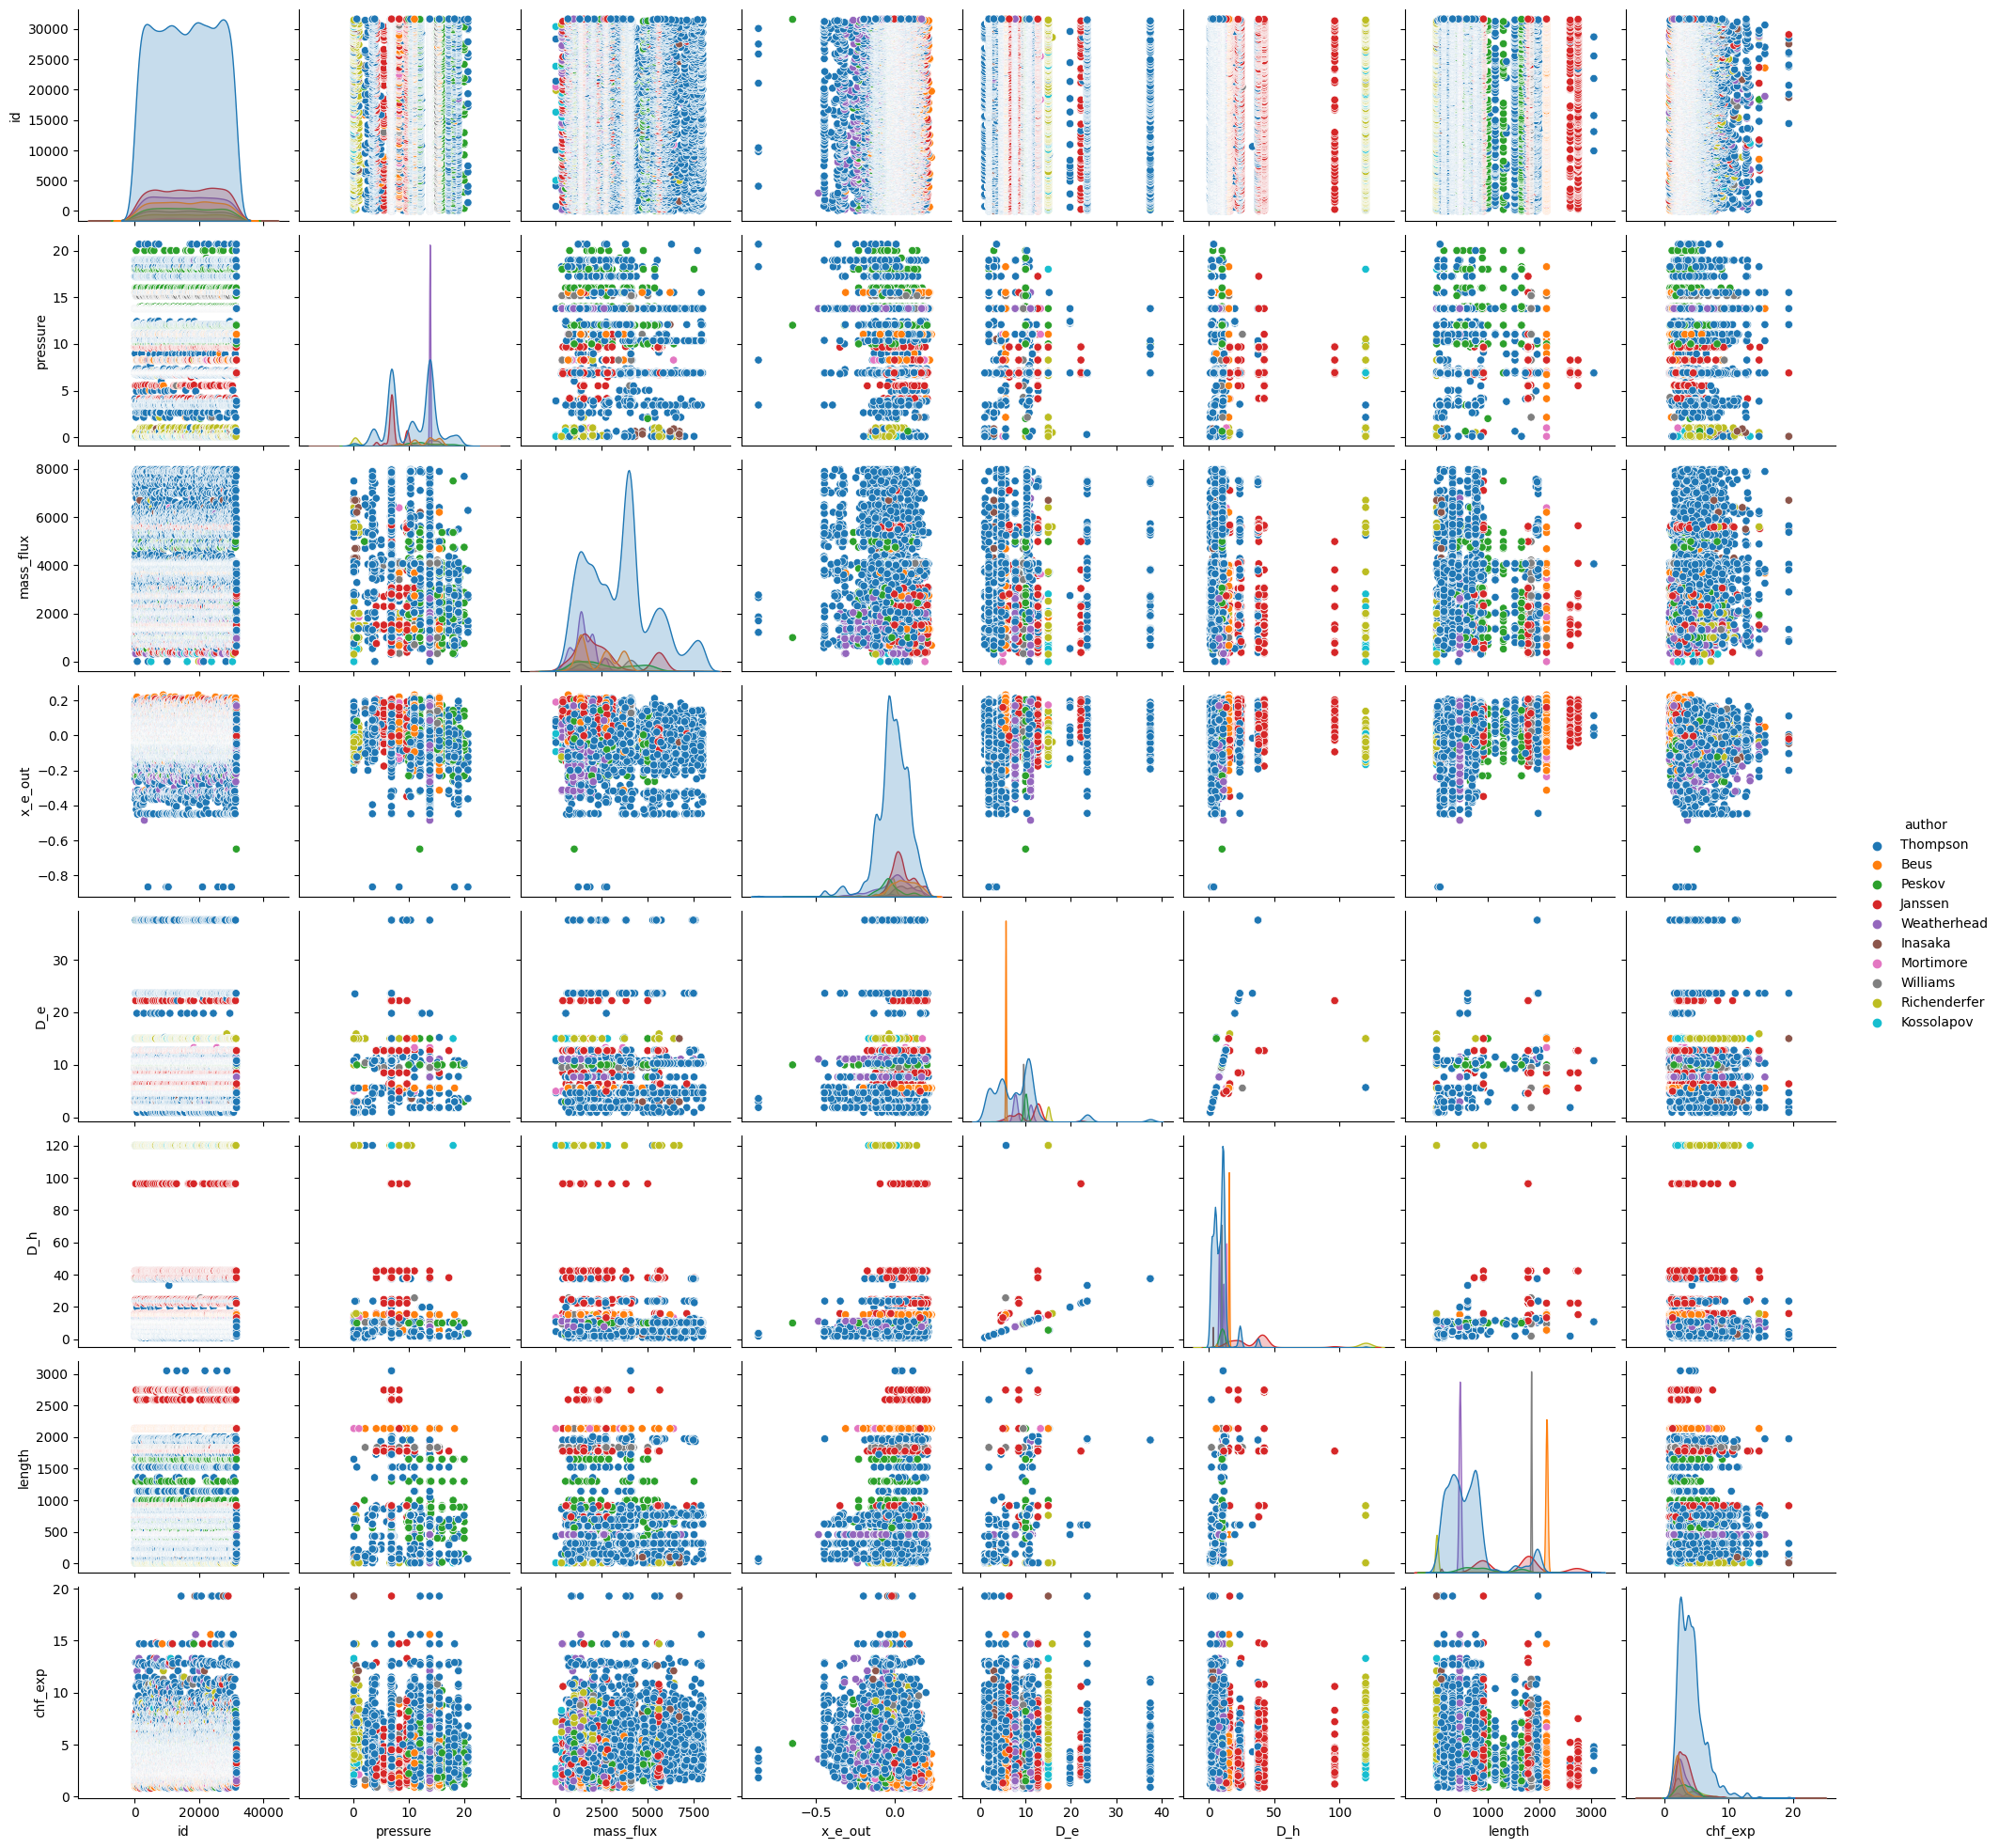

In [15]:
# Plot a pair plot graph
sns.pairplot(df_train, hue='author');

we can see there seems to be a some discint author values on the D_h and x_e_out scatter graph so we can look at this in more detail:

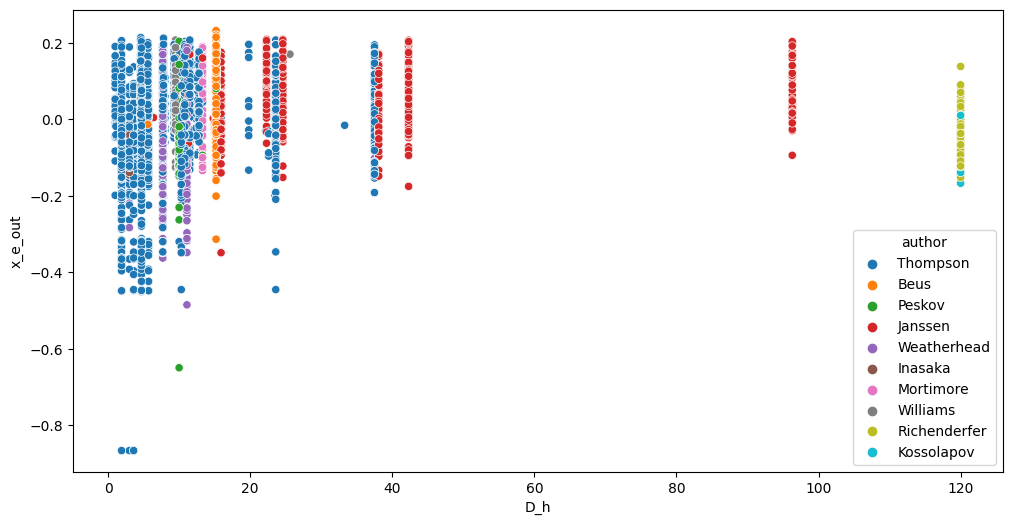

In [16]:
# Plot a scatter graph
plt.figure(figsize=(12, 6))
sns.scatterplot(data = df_train,  x='D_h', y='x_e_out', hue='author');

There doesn't seem to be any correlation between Thompson and Janseen so we can remove these for a better view:

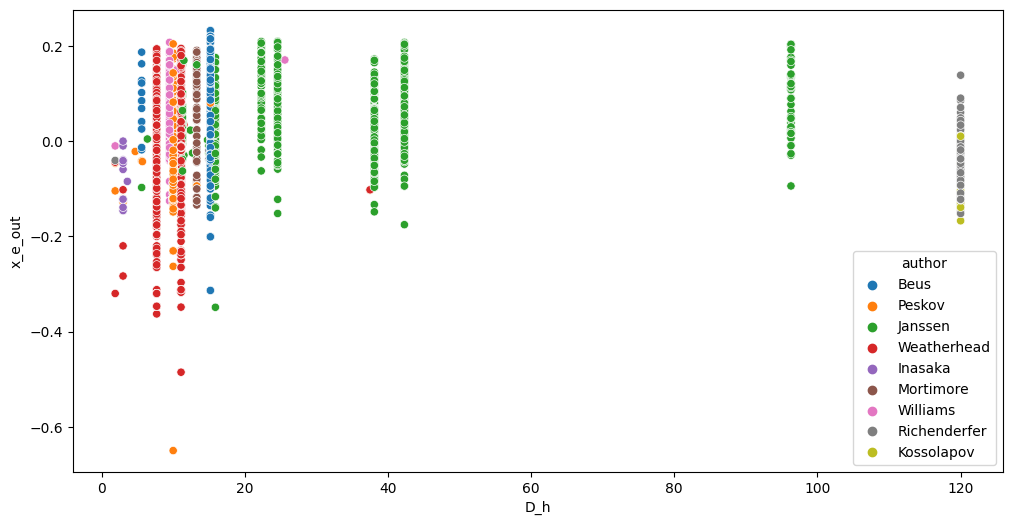

In [17]:
# Plot a scatter graph
plt.figure(figsize=(12, 6))
sns.scatterplot(data = df_train[~df_train.isin(['Thompson'])],  x='D_h', y='x_e_out', hue='author');

Apart from Beus and Weatherhead which have two distinct values, most of these authors have a clearly distinct value of D_h in which they fall, so we can impute the author from these D_h values. However, we know that certain authors fall into strict geometries so we need to esnure that our imputed values align with these:

First we can define a function for imputing top values:

In [18]:
def impute_top_values(df_train, df_test, fill_col, ref_col, fill_col_vals, num_top_ref, *other_ref_col, **other_ref_val):
    
    for author in fill_col_vals:
        top_ref = df_train[df_train[fill_col] == author][ref_col].value_counts().index[:num_top_ref]
        if other_ref_col:
            mask_train = (df_train[ref_col].isin(top_ref)) & ((df_train[other_ref_col] == other_ref_val) | (df_train[other_ref_col].isna()))
            mask_test = (df_test[ref_col].isin(top_ref)) & ((df_test[other_ref_col] == other_ref_val) | (df_test[other_ref_col].isna()))
        else:
            mask_train = df_train[ref_col].isin(top_ref)
            mask_test = df_test[ref_col].isin(top_ref)
        df_train.loc[mask_train, fill_col] = df_train.loc[mask_train, fill_col].fillna(author)
        df_test.loc[mask_test, fill_col] = df_test.loc[mask_test, fill_col].fillna(author)
    
    return df_train, df_test 
        

In [19]:
# plate
df_train, df_test = impute_top_values(df_train, df_test, 'author', 'D_h', ['Richenderfer', 'Kossolapov'], 1, other_ref_col='geometry', other_ref_val='plate')

# annulus
df_train, df_test = impute_top_values(df_train, df_test, 'author', 'D_h', ['Mortimore'], 1, other_ref_col='geometry', other_ref_val='annulus')
df_train, df_test = impute_top_values(df_train, df_test, 'author', 'D_h', ['Beus'], 2, other_ref_col='geometry', other_ref_val='annulus')
df_train, df_test = impute_top_values(df_train, df_test, 'author', 'D_h', ['Janssen'], 6, other_ref_col='geometry', other_ref_val='annulus')

# tube
df_train, df_test = impute_top_values(df_train, df_test, 'author', 'D_h', ['Peskov', 'Inasaka', 'Williams'], 1, other_ref_col='geometry', other_ref_val='tube')
df_train, df_test = impute_top_values(df_train, df_test, 'author', 'D_h', ['Weatherhead'], 2, other_ref_col='geometry', other_ref_val='tube')

In [20]:
# Check the number of missing values
print('Missing author rows (train):', df_train.author.isna().sum())
print('Missing author rows (test):', df_test.author.isna().sum())

Missing author rows (train): 2188
Missing author rows (test): 1044


This has reduced the number of missing values significantly but there a still a lot to fill. We can also look at the relationship between author, length and x_e_out:

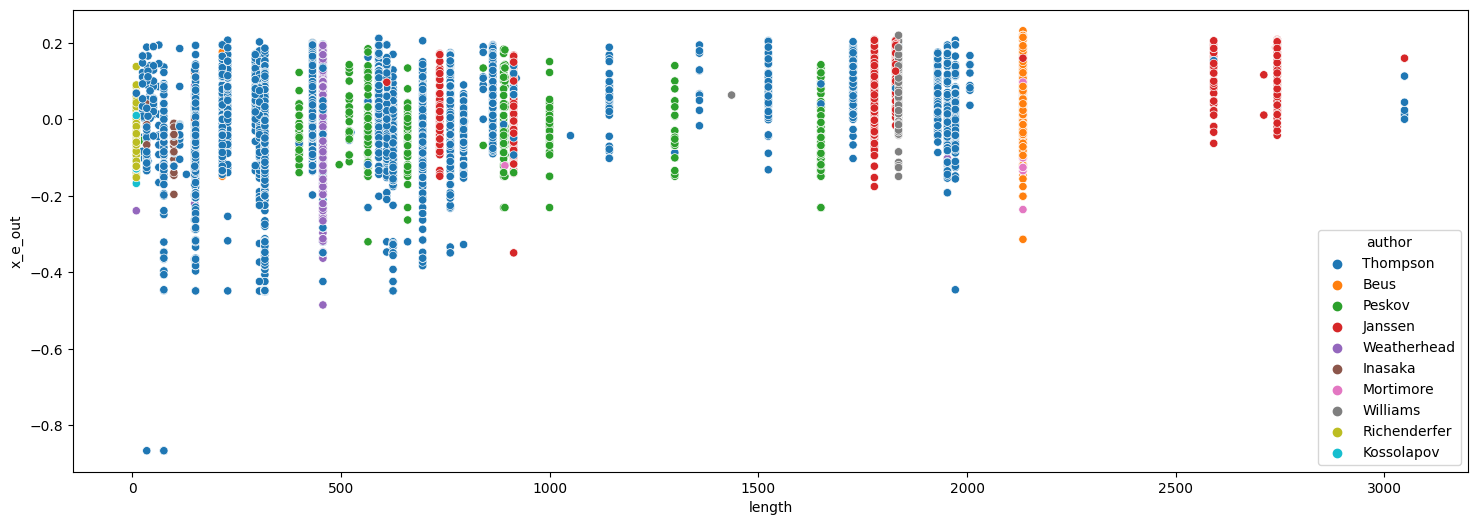

In [21]:
# Plot a scatter graph
plt.figure(figsize=(18, 6))
sns.scatterplot(data = df_train,  x='length', y='x_e_out', hue='author');

We can again see that certain authors fall into unique values of length so we can similarly impute these missing values from these:

In [22]:
# plate
df_train, df_test = impute_top_values(df_train, df_test, 'author', 'length', ['Richenderfer', 'Kossolapov'], 1, other_ref_col='geometry', other_ref_val='plate')

# annulus
df_train, df_test = impute_top_values(df_train, df_test, 'author', 'length', ['Beus', 'Mortimore'], 1, other_ref_col='geometry', other_ref_val='annulus')
df_train, df_test = impute_top_values(df_train, df_test, 'author', 'length', ['Janssen'], 7, other_ref_col='geometry', other_ref_val='annulus')

# tube
df_train, df_test = impute_top_values(df_train, df_test, 'author', 'length', ['Weatherhead', 'Inasaka', 'Williams'], 1, other_ref_col='geometry', other_ref_val='tube')
df_train, df_test = impute_top_values(df_train, df_test, 'author', 'length', ['Peskov'], 8, other_ref_col='geometry', other_ref_val='tube')

In [23]:
# Check the number of missing values
print('Missing author rows (train):', df_train.author.isna().sum())
print('Missing author rows (test):', df_test.author.isna().sum())

Missing author rows (train): 2001
Missing author rows (test): 955


We will finally fill the rest of the missing author values with the most common value Thompson provided that they have a null or 'tube' value for geometry. We can also fill the remaining missing values with the most popular author for that geometry:

In [24]:
# Fill tube and missing geometry values with Thompson
mask_train = (df_train['geometry'] == 'tube') | (df_train['geometry'].isna())
mask_test = (df_test['geometry'] == 'tube') | (df_test['geometry'].isna())
df_train.loc[mask_train, 'author'] = df_train.loc[mask_train, 'author'].fillna('Thompson')
df_test.loc[mask_test, 'author'] = df_test.loc[mask_test, 'author'].fillna('Thompson')

# Fill annulus values with Beus
mask_train = (df_train['geometry'] == 'annulus')
mask_test = (df_test['geometry'] == 'annulus')
df_train.loc[mask_train, 'author'] = df_train.loc[mask_train, 'author'].fillna('Beus')
df_test.loc[mask_test, 'author'] = df_test.loc[mask_test, 'author'].fillna('Beus')

# Fill plate values with Richenderfer
mask_train = (df_train['geometry'] == 'plate')
mask_test = (df_test['geometry'] == 'plate')
df_train.loc[mask_train, 'author'] = df_train.loc[mask_train, 'author'].fillna('Richenderfer')
df_test.loc[mask_test, 'author'] = df_test.loc[mask_test, 'author'].fillna('Richenderfer')


We can check that there are no remaining missing values:

In [25]:
# Check the number of missing values
print('Missing author rows (train):', df_train.author.isna().sum())
print('Missing author rows (test):', df_test.author.isna().sum())

Missing author rows (train): 0
Missing author rows (test): 0


We can now also fill the reamining missing geometry columns by imputing from the author column:

In [26]:
# Fill values with tube
tube_mask_train = df_train['author'].isin(['Thompson', 'Peskov', 'Weatherhead', 'Inasaka', 'Williams'])
tube_mask_test = df_test['author'].isin(['Thompson', 'Peskov', 'Weatherhead', 'Inasaka', 'Williams'])
df_train.loc[tube_mask_train, 'geometry'] = df_train.loc[tube_mask_train, 'geometry'].fillna('tube')
df_test.loc[tube_mask_test, 'geometry'] = df_test.loc[tube_mask_test, 'geometry'].fillna('tube')

# Fill values with annulus
annulus_mask_train = df_train['author'].isin(['Beus', 'Janssen', 'Mortimore'])
annulus_mask_test = df_test['author'].isin(['Beus', 'Janssen', 'Mortimore'])
df_train.loc[annulus_mask_train, 'geometry'] = df_train.loc[annulus_mask_train, 'geometry'].fillna('annulus')
df_test.loc[annulus_mask_test, 'geometry'] = df_test.loc[annulus_mask_test, 'geometry'].fillna('annulus')

# Fill values with plate
plate_mask_train = df_train['author'].isin(['Richenderfer', 'Kossolapov'])
plate_mask_test = df_test['author'].isin(['Richenderfer', 'Kossolapov'])
df_train.loc[plate_mask_train, 'geometry'] = df_train.loc[plate_mask_train, 'geometry'].fillna('plate')
df_test.loc[plate_mask_test, 'geometry'] = df_test.loc[plate_mask_test, 'geometry'].fillna('plate')

In [27]:
print('Missing geometry rows (train):', df_train.geometry.isna().sum())
print('Missing geometry rows (test):', df_test.geometry.isna().sum())

Missing geometry rows (train): 0
Missing geometry rows (test): 0


## Analysis of Numerical Features

First we will look at a correlation matrix to see if there are any highly correlated features we can impute from each other:

In [ ]:
def corr_heatmap(df, corr_type):

        corr = df.corr(method=corr_type)

        mask = np.triu(np.ones_like(corr, dtype=bool))

        plt.figure(figsize=(12, 8))
        
        sns.set_theme(style="white", font_scale=0.8)
        sns.heatmap(corr, cmap="YlOrBr", linewidths=2, mask=mask, vmin=-1, vmax=1, annot=True, fmt=".2f")

        plt.show()

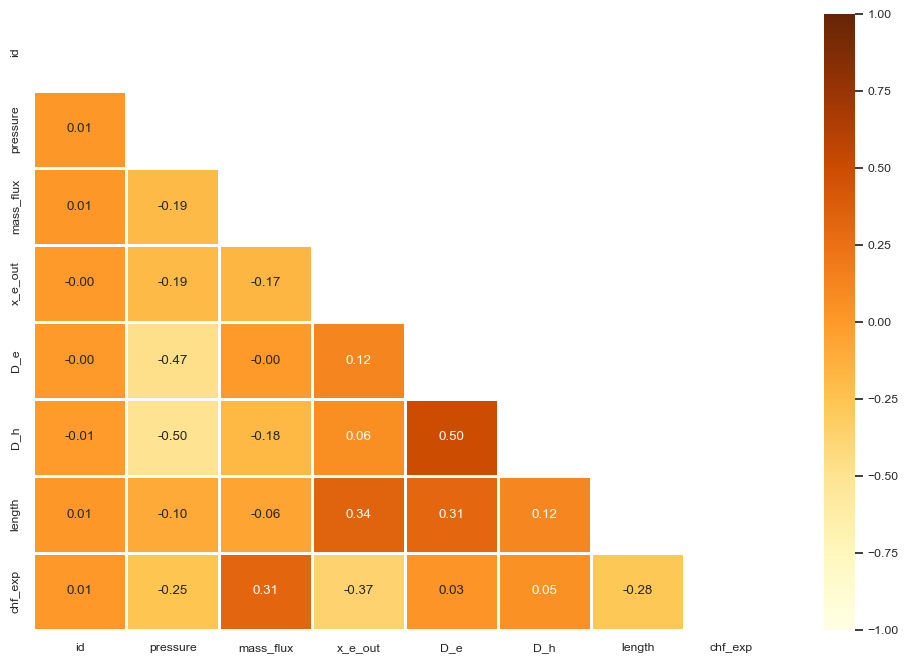

In [28]:
corr_heatmap(df_train.select_dtypes(include='number'), 'pearson')

### D_e & D_h

Since D_e and D_h have a fairly significant correlation, we can use these to impute values for each other. We also know from before that author was also highly correlated with D_h so we can also use this for the imputation: 

In [29]:
print('Missing D_h rows (train):', df_train.D_h.isna().sum())
print('Missing D_h rows (test):', df_test.D_h.isna().sum())
print('\n')
print('Missing D_e rows (train):', df_train.D_e.isna().sum())
print('Missing D_e rows (test):', df_test.D_e.isna().sum())

Missing D_h rows (train): 3127
Missing D_h rows (test): 1462


Missing D_e rows (train): 3641
Missing D_e rows (test): 1847


Correaltion: 0.4955280498382358


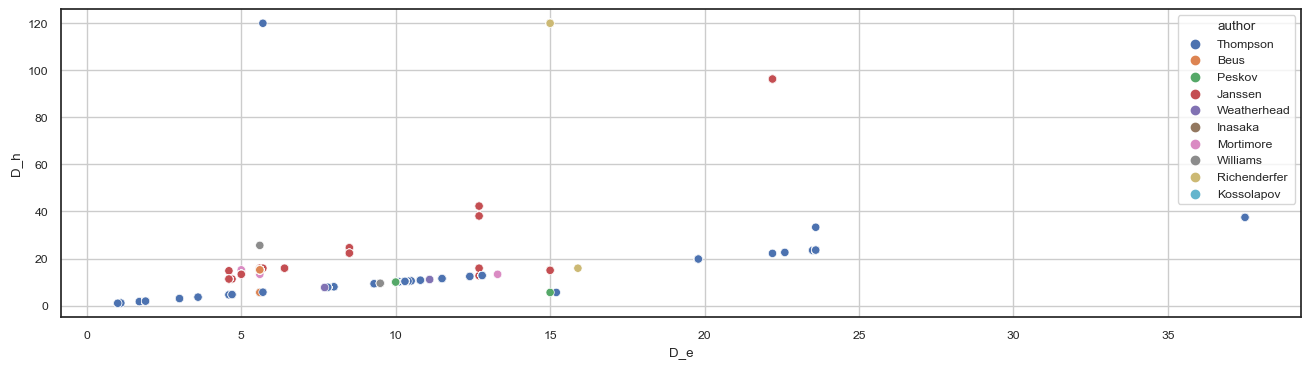

In [30]:
# Plot a scatter graph
plt.figure(figsize=(16, 4))
sns.scatterplot(data=df_train, x='D_e', y='D_h', hue='author')
plt.grid('True')
print('Correaltion:', df_train[['D_h', 'D_e']].corr().loc['D_h', 'D_e'])

We can see from the above scatter graph that a lot of authors fall on a clear correlated line except at certain values suvch as between 4 and 9 D_e.

In [31]:
# Create an exception mask for certain authors or when D_e lies between 4 and 9
exception_mask_train = ((df_train['D_e'] >= 4) & (df_train['D_e'] <= 9)) | (df_train['D_h'] >= 40) | (df_train['author'].isin(['Janssen']))

Correaltion: 0.9984988976953943


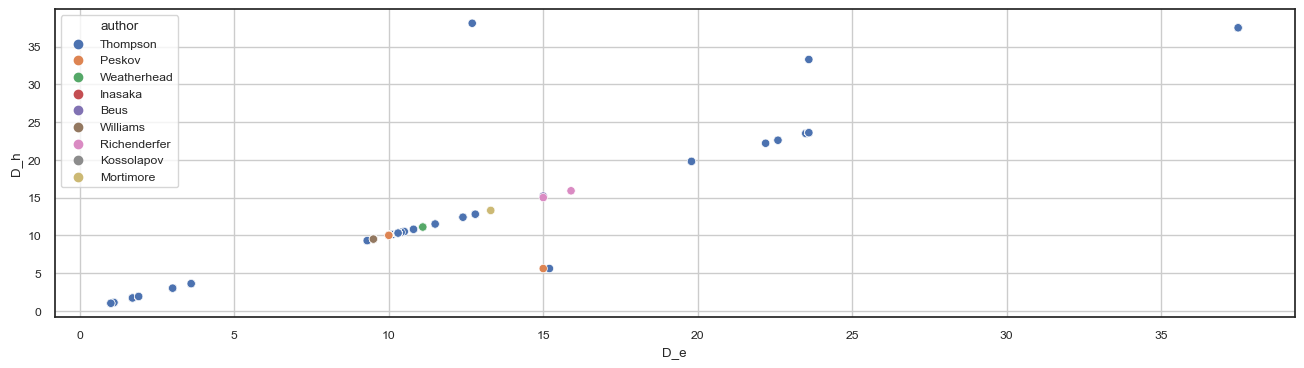

In [32]:
# Plot a scatter graph
plt.figure(figsize=(16, 4))
sns.scatterplot(data=df_train[~exception_mask_train], x='D_e', y='D_h', hue='author')
plt.grid('True')
print('Correaltion:', df_train[~exception_mask_train][['D_h', 'D_e']].corr().loc['D_h', 'D_e'])

We can see above that apart from a few outliers, removing the exceptions as massively increased our correlation. Thefore we can use this to impute our missing values. First we create a function to impute missing values based on two features and an exception mask:

In [33]:
def impute_values_with_exception(df_train, df_test, feature1, feature2, exception_mask_train, exception_mask_test):

    # We get the correlation value for the data without the exceptions
    corr_value = df_train[~exception_mask_train][[feature1, feature2]].corr().loc[feature1, feature2]

    # We create a mask of missing data that doesn't include the exceptions
    missing_mask_train_f1 = df_train[feature1].isna() & (~exception_mask_train)
    missing_mask_test_f1 = df_test[feature1].isna()  & (~exception_mask_test)

    missing_mask_train_f2 = df_train[feature2].isna() & (~exception_mask_train)
    missing_mask_test_f2 = df_test[feature2].isna()  & (~exception_mask_test)

    # We use the correlation coefficient to impute the missing values
    for idx, row in df_train[missing_mask_train_f1].iterrows():
        predicted_f1 = row[feature2] * corr_value
        df_train.at[idx, feature1] = predicted_f1

    for idx, row in df_test[missing_mask_test_f1].iterrows():
        predicted_f1 = row[feature2] * corr_value
        df_test.at[idx, feature1] = predicted_f1

    for idx, row in df_train[missing_mask_train_f2].iterrows():
        predicted_f2 = row[feature1] / corr_value
        df_train.at[idx, feature2] = predicted_f2

    for idx, row in df_test[missing_mask_test_f2].iterrows():
        predicted_f2 = row[feature1] / corr_value
        df_test.at[idx, feature2] = predicted_f2

    return df_train, df_test

Now we can run the function on D_e and D_h with our pre-defined exception mask:

In [34]:
# Create the same exception mask for the test data
exception_mask_test = ((df_test['D_e'] >= 4) & (df_test['D_e'] <= 9)) | (df_test['D_h'] >= 40) | (df_test['author'].isin(['Janssen']))

# Run the function
df_train, df_test = impute_values_with_exception(df_train, df_test, 'D_h', 'D_e', exception_mask_train, exception_mask_test)

In [35]:
print('Missing D_h rows (train):', df_train.D_h.isna().sum())
print('Missing D_h rows (test):', df_test.D_h.isna().sum())
print('\n')
print('Missing D_e rows (train):', df_train.D_e.isna().sum())
print('Missing D_e rows (test):', df_test.D_e.isna().sum())

Missing D_h rows (train): 1762
Missing D_h rows (test): 791


Missing D_e rows (train): 967
Missing D_e rows (test): 440


We can now look into filling the missing values for our exceptions:

Correaltion: 0.8280518820660527


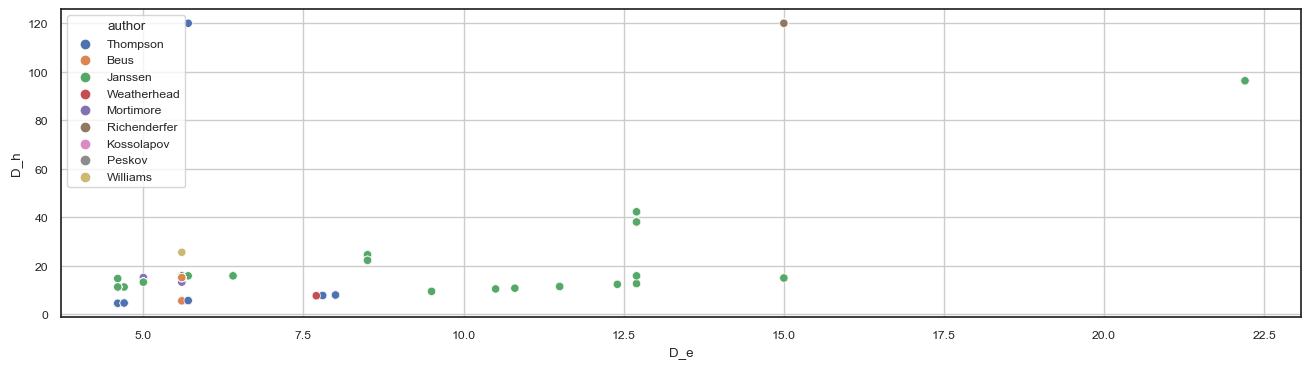

In [36]:
# Plot a scatter graph
plt.figure(figsize=(16, 4))
sns.scatterplot(data=df_train[exception_mask_train], x='D_e', y='D_h', hue='author')
plt.grid('True')
print('Correaltion:', df_train[exception_mask_train][['D_h', 'D_e']].corr().loc['D_h', 'D_e'])

We can now impute the remaining outliers that fall under 60 D_h:

In [37]:
# Create exception masks
exception_mask_train2 = df_train['D_h'] >= 60
exception_mask_test2 = df_test['D_h'] >= 60

# Run imputation function
df_train, df_test = impute_values_with_exception(df_train, df_test, 'D_h', 'D_e', exception_mask_train2, exception_mask_test2)

In [38]:
print('Missing D_h rows (train):', df_train.D_h.isna().sum())
print('Missing D_h rows (test):', df_test.D_h.isna().sum())
print('\n')
print('Missing D_e rows (train):', df_train.D_e.isna().sum())
print('Missing D_e rows (test):', df_test.D_e.isna().sum())

Missing D_h rows (train): 556
Missing D_h rows (test): 259


Missing D_e rows (train): 656
Missing D_e rows (test): 294


Now we can look at the remaining values:

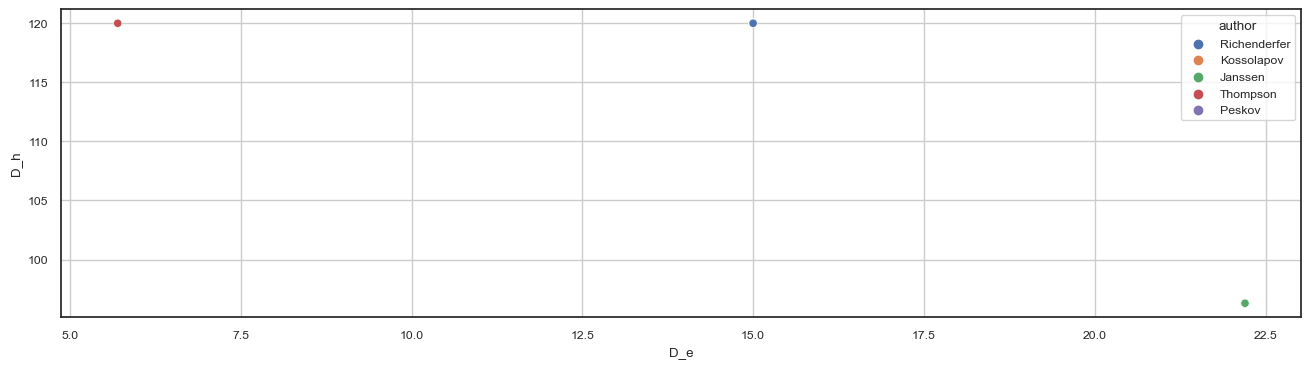

In [39]:
# Plot a scatter graph
plt.figure(figsize=(16, 4))
sns.scatterplot(data=df_train[exception_mask_train2], x='D_e', y='D_h', hue='author')
plt.grid('True')


In [40]:
df_train[exception_mask_train2][['D_h', 'D_e']].value_counts()

D_h    D_e 
120.0  15.0    365
96.3   22.2     54
120.0  5.7       1
Name: count, dtype: int64

Since only one value exists with a D_h of 120 and a D_e of 5.7, we can ignore this and impute the other values from each other: 

In [41]:
df_train.loc[df_train['D_h'] == 120.0, 'D_e'] = df_train.loc[df_train['D_h'] == 120.0, 'D_e'].fillna(15.0)
df_test.loc[df_test['D_h'] == 120.0, 'D_e'] = df_test.loc[df_test['D_h'] == 120.0, 'D_e'].fillna(15.0)

df_train.loc[df_train['D_e'] == 15.0, 'D_h'] = df_train.loc[df_train['D_e'] == 15.0, 'D_h'].fillna(120.0)
df_test.loc[df_test['D_e'] == 15.0, 'D_h'] = df_test.loc[df_test['D_e'] == 15.0, 'D_h'].fillna(120.0)

df_train.loc[df_train['D_h'] == 96.3, 'D_e'] = df_train.loc[df_train['D_h'] == 96.3, 'D_e'].fillna(22.2)
df_test.loc[df_test['D_h'] == 96.3, 'D_e'] = df_test.loc[df_test['D_h'] == 96.3, 'D_e'].fillna(22.2)

df_train.loc[df_train['D_e'] == 22.2, 'D_h'] = df_train.loc[df_train['D_e'] == 22.2, 'D_h'].fillna(96.3)
df_test.loc[df_test['D_e'] == 22.2, 'D_h'] = df_test.loc[df_test['D_e'] == 22.2, 'D_h'].fillna(96.3)


In [42]:
print('Missing D_h rows (train):', df_train.D_h.isna().sum())
print('Missing D_h rows (test):', df_test.D_h.isna().sum())
print('\n')
print('Missing D_e rows (train):', df_train.D_e.isna().sum())
print('Missing D_e rows (test):', df_test.D_e.isna().sum())
print('\n')

null_count_train = df_train[(df_train['D_e'].isnull()) & (df_train['D_h'].isnull())].shape[0]
null_count_test = df_test[(df_test['D_e'].isnull()) & (df_test['D_h'].isnull())].shape[0]
print("Number of rows where both D_e and D_h are missing (train):", null_count_train)
print("Number of rows where both D_e and D_h are missing (test):", null_count_test)

Missing D_h rows (train): 556
Missing D_h rows (test): 259


Missing D_e rows (train): 556
Missing D_e rows (test): 259


Number of rows where both D_e and D_h are missing (train): 556
Number of rows where both D_e and D_h are missing (test): 259


We can see above that the only remaining missing values are those where both are missing. we will leave these for now. 

## Imputing Remaining Numerical Features

For the remaining numerical features, we can use IterativeImputer to fill the remaining values. However, first we will need to encode the categorical features:

In [103]:
# First we define X and y
X_train = df_train.drop(columns=['id', 'x_e_out'], axis=1)
X_test = df_test.drop(columns=['id', 'x_e_out'], axis=1)

y_train = df_train['x_e_out']

In [104]:
# Encode categorical columns
X_train = pd.get_dummies(X_train, columns=['author', 'geometry'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['author', 'geometry'], drop_first=True)

In [105]:
imputer = IterativeImputer(random_state=42)

X_train[:] = imputer.fit_transform(X_train)
X_test[:] = imputer.transform(X_test)

In [106]:
print('Missing rows (train):', X_train.isna().sum().sum())
print('Missing rows (test):', X_test.isna().sum().sum())

Missing rows (train): 0
Missing rows (test): 0


## Model Building

Now that we have no more missing values, we can look into building some models. First we need to split our training data into a training and validation set:

In [107]:
# Train/test split
X_train2, X_val, y_train2, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

In [89]:
# Save to files
X_train2.to_csv('X_train2.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
y_train2.to_csv('y_train2.csv', index=False)
y_val.to_csv('y_val.csv', index=False)

We will first get some baseline model results:

In [90]:
# Linear Regression

# Scale data
ss = StandardScaler()
X_train2_ss = ss.fit_transform(X_train2)
X_val_ss = ss.transform(X_val)

# Create and fit model 
lr = LinearRegression()
lr.fit(X_train2_ss, y_train2)

# Create predictions
y_pred_lr = lr.predict(X_val_ss)

# Evaluate model
rmse_lr = mean_squared_error(y_pred_lr, y_val, squared=False)


In [109]:
# Random Forest

# Create and fit model 
rf = RandomForestRegressor()
rf.fit(X_train2, y_train2)

# Create predictions
y_pred_rf = rf.predict(X_val)

# Evaluate model
rmse_rf = mean_squared_error(y_pred_rf, y_val, squared=False)

In [110]:
# XGBoost

# Create and fit model 
xg = XGBRegressor()
xg.fit(X_train2, y_train2)

# Create predictions
y_pred_xg = xg.predict(X_val)

# Evaluate model
rmse_xg = mean_squared_error(y_pred_xg, y_val, squared=False)

In [111]:
# Show results
print('Linear Regression Mean Absolute Error:', rmse_lr.round(5))
print('Random Forest Mean Absolute Error:', rmse_rf.round(5))
print('XGBoost Mean Absolute Error:', rmse_xg.round(5))

Linear Regression Mean Absolute Error: 0.08479
Random Forest Mean Absolute Error: 0.07913
XGBoost Mean Absolute Error: 0.07594


These are some good baseline model figures but we can see how they can be improved with some hyperparameter tuning using Optuna:

We cun use Optuna to build an Elastic Net model

In [112]:
def objective(trial):
    # Define hyperparameter ranges for the Elastic Net model
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-6, 10),
        'l1_ratio': trial.suggest_uniform('l1_ratio', 0, 1),
        'max_iter': trial.suggest_int('max_iter', 100, 1000, step=100),
        'tol': trial.suggest_loguniform('tol', 1e-6, 1e-2)
    }

    # Train the Elastic Net model using cross-validation and return the average R2 score
    en = ElasticNet(**params)
    scores = cross_val_score(en, X_train2_ss, y_train2, cv=5, scoring='neg_mean_squared_error')
    rmse_mean = scores.mean()
    return rmse_mean

study1 = optuna.create_study(direction='maximize')
study1.optimize(objective, n_trials=200)

[I 2023-05-24 16:46:38,980] A new study created in memory with name: no-name-d0b74863-b513-44c8-823c-3ee54a7f37f9
[I 2023-05-24 16:46:43,846] Trial 0 finished with value: -0.007430897066431871 and parameters: {'alpha': 5.142715450568413e-05, 'l1_ratio': 0.2777630845838144, 'max_iter': 800, 'tol': 7.703515728250421e-05}. Best is trial 0 with value: -0.007430897066431871.
[I 2023-05-24 16:46:47,702] Trial 1 finished with value: -0.0074309137397103875 and parameters: {'alpha': 3.403715107166904e-05, 'l1_ratio': 0.08918485596489667, 'max_iter': 300, 'tol': 0.0004800058865056985}. Best is trial 0 with value: -0.007430897066431871.
[I 2023-05-24 16:46:48,363] Trial 2 finished with value: -0.007432085110037586 and parameters: {'alpha': 0.00011460534624758973, 'l1_ratio': 0.7790134216846188, 'max_iter': 400, 'tol': 0.0029951840713502795}. Best is trial 0 with value: -0.007430897066431871.
[I 2023-05-24 16:46:53,226] Trial 3 finished with value: -0.007430962615440362 and parameters: {'alpha': 3

Now we can fit the model with the optimised parameters:

In [113]:
# Define random Elastic Net with optimised hyperparameters
en = ElasticNet(alpha=study1.best_params['alpha'],
                            l1_ratio=study1.best_params['l1_ratio'],
                            max_iter=study1.best_params['max_iter'],
                            tol=study1.best_params['tol'],
                            random_state=42)

# Fit the regressor with the training data
en.fit(X_train2_ss, y_train2)

# Make predictions on the test data
y_pred_en = en.predict(X_val_ss)

# Evaluate the performance of the model using mean absolute error
rmse_en = mean_squared_error(y_val, y_pred_en, squared=False)

We can use Optuna to tune our hyperparameters for a Random Forest model:

In [114]:
# Define objective function for hyperparameter optimisation
def objective(trial):
    # Define hyperparameters to be optimized
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 50, 100),
        'max_depth' : trial.suggest_int('max_depth', 2, 10),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 5)
    }
    
    # Create an XGBoost regressor model with the given hyperparameters
    rf = RandomForestRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(rf, X_train2, y_train2, cv=5, scoring='neg_mean_squared_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study2 = optuna.create_study(direction='maximize') 
study2.optimize(objective, n_trials=200)

[I 2023-05-24 16:54:14,914] A new study created in memory with name: no-name-803611a6-aa01-42e3-9cea-fbf04a7e0806
[I 2023-05-24 16:54:23,818] Trial 0 finished with value: -0.005735127330499748 and parameters: {'n_estimators': 66, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: -0.005735127330499748.
[I 2023-05-24 16:54:32,906] Trial 1 finished with value: -0.005997367632750769 and parameters: {'n_estimators': 99, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 0 with value: -0.005735127330499748.
[I 2023-05-24 16:54:40,758] Trial 2 finished with value: -0.00586086668153835 and parameters: {'n_estimators': 74, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: -0.005735127330499748.
[I 2023-05-24 16:54:50,004] Trial 3 finished with value: -0.005765544551035684 and parameters: {'n_estimators': 77, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial

Now we can fit the model with the optimised parameters:

In [115]:
# Define random forest regressor with optimised hyperparameters
rf = RandomForestRegressor(n_estimators=study2.best_params['n_estimators'],
                            max_depth=study2.best_params['max_depth'],
                            min_samples_split=study2.best_params['min_samples_split'],
                            min_samples_leaf=study2.best_params['min_samples_leaf'],
                            random_state=42)

# Fit the regressor with the training data
rf.fit(X_train2, y_train2)

# Make predictions on the test data
y_pred_rf = rf.predict(X_val)

# Evaluate the performance of the model using mean absolute error
rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False)

In [163]:
# Define objective function for hyperparameter optimisation
def objective(trial):

    # Define hyperparameters to be optimised
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'reg:squarederror',
        'random_state': 42
    }


    # Create an XGBoost regressor model with the given hyperparameters
    xg = XGBRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(xg, X_train2, y_train2, cv=5, scoring='neg_mean_squared_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study3 = optuna.create_study(direction='maximize') 
study3.optimize(objective, n_trials=200)

[I 2023-05-25 11:10:32,958] A new study created in memory with name: no-name-5e7e7245-0c43-4d3b-8e0b-eabdd2aafc9e
[I 2023-05-25 11:10:36,846] Trial 0 finished with value: -0.005678212433002671 and parameters: {'n_estimators': 99, 'max_depth': 9, 'learning_rate': 0.06741445810858579, 'subsample': 0.9976530118605149, 'colsample_bytree': 0.7338580429194457, 'min_child_weight': 2}. Best is trial 0 with value: -0.005678212433002671.
[I 2023-05-25 11:10:37,884] Trial 1 finished with value: -0.00627605322603062 and parameters: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05799656974654459, 'subsample': 0.9749957181746185, 'colsample_bytree': 0.9334915650295365, 'min_child_weight': 6}. Best is trial 0 with value: -0.005678212433002671.
[I 2023-05-25 11:10:39,797] Trial 2 finished with value: -0.00580398001741039 and parameters: {'n_estimators': 68, 'max_depth': 6, 'learning_rate': 0.05493468075945707, 'subsample': 0.6470324664740714, 'colsample_bytree': 0.8999278983550654, 'min_chi

In [164]:
# Define random forest regressor with optimized hyperparameters
xg = XGBRegressor(
                            n_estimators = study3.best_params['n_estimators'],
                            max_depth = study3.best_params['max_depth'],
                            learning_rate = study3.best_params['learning_rate'],
                            subsample = study3.best_params['subsample'],
                            colsample_bytree = study3.best_params['colsample_bytree'],
                            min_child_weight = study3.best_params['min_child_weight'],
                            random_state=42
)

# Fit the regressor with the training data
xg.fit(X_train2, y_train2)

# Make predictions on the test data
y_pred_xg = xg.predict(X_val)

# Evaluate the performance of the model using mean absolute error
rmse_xg = mean_squared_error(y_val, y_pred_xg, squared=False)


In [166]:
# Show results
print('Elastic Net Mean Absolute Error:', rmse_en.round(5))
print('Random Forest Mean Absolute Error:', rmse_rf.round(5))
print('XGBoost Mean Absolute Error:', rmse_xg.round(5))

Elastic Net Mean Absolute Error: 0.0848
Random Forest Mean Absolute Error: 0.07454
XGBoost Mean Absolute Error: 0.07321


We can look at the most important features for our models and decide whether to drop any with low importance:

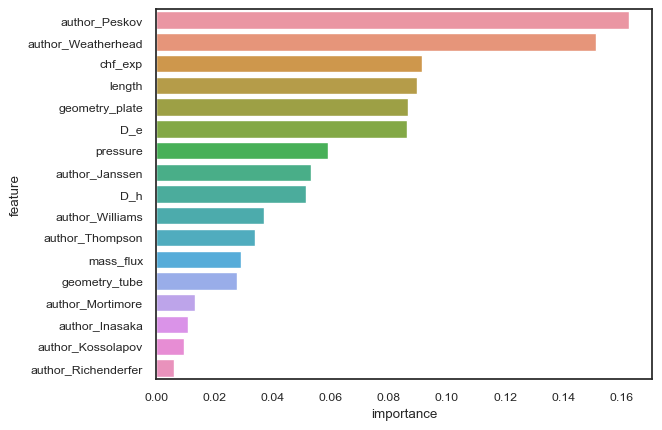

In [119]:
# Get feature importances based on gain
importances = xg.feature_importances_

feature_names = X_train.columns

# Create a dataframe of feature importances
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the dataframe by importance in descending order
df_importances = df_importances.sort_values('importance', ascending=False)

# Create a barplot of feature importances
sns.barplot(x='importance', y='feature', data=df_importances);

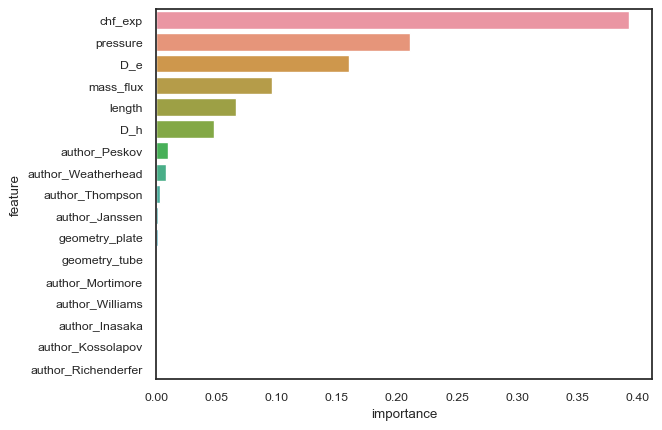

In [120]:
# Get feature importances based on gain
importances = rf.feature_importances_

feature_names = X_train.columns

# Create a dataframe of feature importances
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the dataframe by importance in descending order
df_importances = df_importances.sort_values('importance', ascending=False)

# Create a barplot of feature importances
sns.barplot(x='importance', y='feature', data=df_importances);

This model performs very slightly better than before but with fewer features we have reducded the time it takes to train and increased the interprability. 

Since our boosted and ensemble models have been performing best, we can try out some other types of these models to see if we can increase our performance metric further:

Catboost:

In [153]:
# Define objective function for hyperparameter optimisation
def objective(trial):

    # Define hyperparameters to be optimised
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_state': 42,
        'verbose': False
    }

    # Create a CatBoost regressor model with the given hyperparameters
    cb = CatBoostRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(cb, X_train2, y_train2, cv=5, scoring='neg_mean_squared_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study4 = optuna.create_study(direction='maximize') 
study4.optimize(objective, n_trials=200)

[I 2023-05-24 19:38:20,916] A new study created in memory with name: no-name-f0257e0f-c8ff-4e41-a34a-9da934a57300
[I 2023-05-24 19:38:24,388] Trial 0 finished with value: -0.0057659438645300005 and parameters: {'n_estimators': 76, 'max_depth': 7, 'learning_rate': 0.09629118888932216, 'subsample': 0.5844787598457157, 'colsample_bylevel': 0.6658981510881171, 'l2_leaf_reg': 3.5566052986284493}. Best is trial 0 with value: -0.0057659438645300005.
[I 2023-05-24 19:38:25,317] Trial 1 finished with value: -0.006946109159347022 and parameters: {'n_estimators': 97, 'max_depth': 2, 'learning_rate': 0.03057751327816826, 'subsample': 0.5540840019974976, 'colsample_bylevel': 0.5780271081549688, 'l2_leaf_reg': 6.100398676444204}. Best is trial 0 with value: -0.0057659438645300005.
[I 2023-05-24 19:38:27,106] Trial 2 finished with value: -0.00851338904522463 and parameters: {'n_estimators': 52, 'max_depth': 7, 'learning_rate': 0.006776467657420559, 'subsample': 0.5633342965445336, 'colsample_bylevel'

In [154]:
# Define the CatBoost regressor with optimized hyperparameters
cb = CatBoostRegressor(
        n_estimators=study4.best_params['n_estimators'],
        max_depth=study4.best_params['max_depth'],
        learning_rate=study4.best_params['learning_rate'],
        subsample=study4.best_params['subsample'],
        colsample_bylevel=study4.best_params['colsample_bylevel'],
        l2_leaf_reg=study4.best_params['l2_leaf_reg'],
        random_state=42
)

# Fit the regressor with the training data
cb.fit(X_train2, y_train2, verbose=False)

# Make predictions on the test data
y_pred_cb = cb.predict(X_val)

# Evaluate the performance of the model using mean absolute error
rmse_cb = mean_squared_error(y_val, y_pred_cb, squared=False)

LightGBM:

In [155]:
# Define objective function for hyperparameter optimisation
def objective(trial):

    # Define hyperparameters to be optimised
    param = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'random_state': 42,
        'verbosity': -1
    }

    # Create a LightGBM regressor model with the given hyperparameters
    lgbm = LGBMRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(lgbm, X_train2, y_train2, cv=5, scoring='neg_mean_squared_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study5 = optuna.create_study(direction='maximize') 
study5.optimize(objective, n_trials=200)

[I 2023-05-24 20:01:52,450] A new study created in memory with name: no-name-6ebd5373-3797-4df6-ac87-e113eadecd28
[I 2023-05-24 20:01:52,966] Trial 0 finished with value: -0.0057916436435850255 and parameters: {'n_estimators': 68, 'max_depth': 6, 'learning_rate': 0.039219489709481276, 'subsample': 0.7774522152608506, 'colsample_bytree': 0.8641527951353565, 'min_child_samples': 3}. Best is trial 0 with value: -0.0057916436435850255.
[I 2023-05-24 20:01:53,472] Trial 1 finished with value: -0.00577475998123568 and parameters: {'n_estimators': 95, 'max_depth': 4, 'learning_rate': 0.05487930275853688, 'subsample': 0.6881468238814377, 'colsample_bytree': 0.6038050458870446, 'min_child_samples': 5}. Best is trial 1 with value: -0.00577475998123568.
[I 2023-05-24 20:01:53,954] Trial 2 finished with value: -0.007120639608807397 and parameters: {'n_estimators': 90, 'max_depth': 4, 'learning_rate': 0.011663467577245182, 'subsample': 0.8871134232163873, 'colsample_bytree': 0.7117249156727564, 'mi

In [156]:
# Define the LGBMRegressor with optimized hyperparameters
lgbm = LGBMRegressor(
        n_estimators=study5.best_params['n_estimators'],
        max_depth=study5.best_params['max_depth'],
        learning_rate=study5.best_params['learning_rate'],
        subsample=study5.best_params['subsample'],
        colsample_bytree=study5.best_params['colsample_bytree'],
        min_child_samples=study5.best_params['min_child_samples'],
        random_state=42,
        verbosity=-1
)

# Fit the regressor with the training data
lgbm.fit(X_train2, y_train2)

# Make predictions on the validation data
y_pred_lgbm = lgbm.predict(X_val)

# Evaluate the performance of the model using mean absolute error
rmse_lgbm = mean_squared_error(y_val, y_pred_lgbm, squared=False)

ExtraTree:

In [157]:
# Define objective function for hyperparameter optimisation
def objective(trial):

    # Define hyperparameters to be optimised
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.5, 1),
        'random_state': 42
    }

    # Create an ExtraTrees regressor model with the given hyperparameters
    et = ExtraTreesRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(et, X_train2, y_train2, cv=5, scoring='neg_mean_squared_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study6 = optuna.create_study(direction='maximize') 
study6.optimize(objective, n_trials=200)

[I 2023-05-24 20:03:33,232] A new study created in memory with name: no-name-d8667720-5d97-4fc2-ad69-5c1c88f7071a
[I 2023-05-24 20:03:35,208] Trial 0 finished with value: -0.00614976514911061 and parameters: {'n_estimators': 69, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 0.8652807912218364}. Best is trial 0 with value: -0.00614976514911061.
[I 2023-05-24 20:03:35,957] Trial 1 finished with value: -0.007920897266066679 and parameters: {'n_estimators': 61, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 0.9227694754969658}. Best is trial 0 with value: -0.00614976514911061.
[I 2023-05-24 20:03:37,799] Trial 2 finished with value: -0.00683193068715642 and parameters: {'n_estimators': 93, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.878198492421181}. Best is trial 0 with value: -0.00614976514911061.
[I 2023-05-24 20:03:38,461] Trial 3 finished with value: -0.008495610824955133 and parame

In [158]:
# Define ExtraTreesRegressor with optimized hyperparameters
et = ExtraTreesRegressor(
        n_estimators=study6.best_params['n_estimators'],
        max_depth=study6.best_params['max_depth'],
        min_samples_split=study6.best_params['min_samples_split'],
        min_samples_leaf=study6.best_params['min_samples_leaf'],
        max_features=study6.best_params['max_features'],
        random_state=42
)

# Fit the regressor with the training data
et.fit(X_train2, y_train2)

# Make predictions on the test data
y_pred_et = et.predict(X_val)

# Evaluate the performance of the model using mean absolute error
rmse_et = mean_squared_error(y_val, y_pred_et, squared=False)

GradientBoosting:

In [159]:
# Define objective function for hyperparameter optimization
def objective(trial):

    # Define hyperparameters to be optimized
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42
    }

    # Create a Gradient Boosting Regressor model with the given hyperparameters
    gb = GradientBoostingRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(gb, X_train2, y_train2, cv=5, scoring='neg_mean_squared_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study7 = optuna.create_study(direction='maximize') 
study7.optimize(objective, n_trials=200)

[I 2023-05-24 20:10:22,745] A new study created in memory with name: no-name-d5fe078b-5b20-45d9-bb6a-96f4a7933c1f
[I 2023-05-24 20:10:33,169] Trial 0 finished with value: -0.005739169370358508 and parameters: {'n_estimators': 81, 'max_depth': 9, 'learning_rate': 0.08363927529345964, 'subsample': 0.9625351508083253, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 0 with value: -0.005739169370358508.
[I 2023-05-24 20:10:37,212] Trial 1 finished with value: -0.0056975030919226965 and parameters: {'n_estimators': 56, 'max_depth': 6, 'learning_rate': 0.05493582554937391, 'subsample': 0.6994117532505656, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 1 with value: -0.0056975030919226965.
[I 2023-05-24 20:10:43,242] Trial 2 finished with value: -0.0056479023880616755 and parameters: {'n_estimators': 81, 'max_depth': 5, 'learning_rate': 0.09158730125235655, 'subsample': 0.9273396473712103, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 2 with value: 

In [160]:
gb = GradientBoostingRegressor(
        n_estimators=study7.best_params['n_estimators'],
        max_depth=study7.best_params['max_depth'],
        learning_rate=study7.best_params['learning_rate'],
        subsample=study7.best_params['subsample'],
        min_samples_split=study7.best_params['min_samples_split'],
        min_samples_leaf=study7.best_params['min_samples_leaf'],
        random_state=42
)

# Fit the regressor with the training data
gb.fit(X_train2, y_train2)

# Make predictions on the test data
y_pred_gb = gb.predict(X_val)

# Evaluate the performance of the model using mean absolute error
rmse_gb = mean_squared_error(y_val, y_pred_gb, squared=False)

We can compare the mean absolute error scores for all our models:

In [165]:
# Show results
print('Elastic Net Mean Absolute Error:', rmse_en.round(6))
print('Random Forest Mean Absolute Error:', rmse_rf.round(6))
print('XGBoost Mean Absolute Error:', rmse_xg.round(6))
print('Catboost Mean Absolute Error:', rmse_cb.round(6))
print('LightGBM Mean Absolute Error:', rmse_lgbm.round(6))
print('ExtraTree Mean Absolute Error:', rmse_et.round(6))
print('GradientBoost Mean Absolute Error:', rmse_gb.round(6))

Elastic Net Mean Absolute Error: 0.084797
Random Forest Mean Absolute Error: 0.074537
XGBoost Mean Absolute Error: 0.073208
Catboost Mean Absolute Error: 0.07382
LightGBM Mean Absolute Error: 0.073495
ExtraTree Mean Absolute Error: 0.075452
GradientBoost Mean Absolute Error: 0.073584


## Building the Final Model

Since our XGBoost model worked the best on our training and validation set, we can train it on the whole training dataset before making our predictions on the test dataset. 

In [125]:
# Define objective function for hyperparameter optimisation
def objective(trial):

    # Define hyperparameters to be optimised
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'objective': 'reg:squarederror',
        'random_state': 42
    }

    # Create an XGBoost regressor model with the given hyperparameters
    xg = XGBRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(xg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study_final = optuna.create_study(direction='maximize') 
study_final.optimize(objective, n_trials=500)

[I 2023-05-24 17:40:07,264] A new study created in memory with name: no-name-0aa8ea9f-cf46-4472-8a8c-aa0c7056fb2f
[I 2023-05-24 17:40:12,719] Trial 0 finished with value: -0.005666621043790389 and parameters: {'n_estimators': 136, 'max_depth': 7, 'learning_rate': 0.1867943893282941, 'subsample': 0.5682974230019052, 'colsample_bytree': 0.8257083642918904, 'min_child_weight': 17}. Best is trial 0 with value: -0.005666621043790389.
[I 2023-05-24 17:40:16,149] Trial 1 finished with value: -0.005497337230966964 and parameters: {'n_estimators': 165, 'max_depth': 4, 'learning_rate': 0.12821452744641243, 'subsample': 0.7042670331239891, 'colsample_bytree': 0.556560966695042, 'min_child_weight': 18}. Best is trial 1 with value: -0.005497337230966964.
[I 2023-05-24 17:40:20,520] Trial 2 finished with value: -0.005540189281514141 and parameters: {'n_estimators': 160, 'max_depth': 5, 'learning_rate': 0.14492091406391697, 'subsample': 0.768955106549386, 'colsample_bytree': 0.9972393264274935, 'min_

In [126]:
# Define random forest regressor with optimized hyperparameters
xg = XGBRegressor(
                            n_estimators = study_final.best_params['n_estimators'],
                            max_depth = study_final.best_params['max_depth'],
                            learning_rate = study_final.best_params['learning_rate'],
                            subsample = study_final.best_params['subsample'],
                            colsample_bytree = study_final.best_params['colsample_bytree'],
                            min_child_weight = study_final.best_params['min_child_weight'],
                            random_state=42
)

# Fit the regressor with the training data
xg.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xg = xg.predict(X_test)


We can look at the most important features for our model:

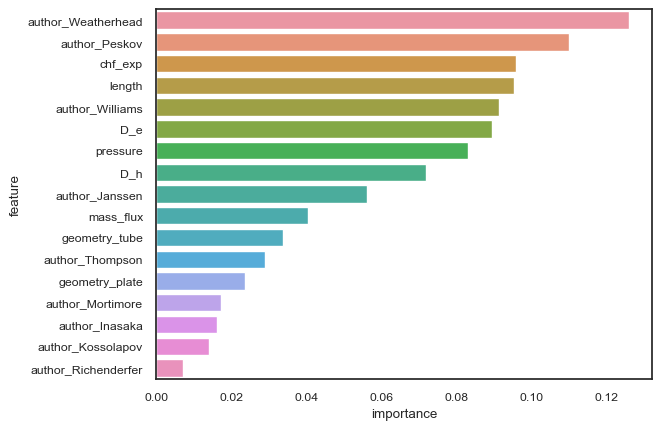

In [128]:
# Get feature importances based on gain
importances = xg.feature_importances_

feature_names = X_train.columns

# Create a dataframe of feature importances
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the dataframe by importance in descending order
df_importances = df_importances.sort_values('importance', ascending=False)

# Create a barplot of feature importances
sns.barplot(x='importance', y='feature', data=df_importances);

Finally we can save our submission:

In [147]:
submission = pd.DataFrame(df_test['id'])
submission['x_e_out [-]'] = y_pred_xg
submission.to_csv('submission1.csv', index=False)